### Задание
Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

Подберите параметры модели SARIMAX для этого ряда.

Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [78]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Описательная статистика практически не изменилась после обработки пропусков, сортировки и удаления дублей.

In [79]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


Общий вид изменения ключевого свойства ряда приведен на рис.1.

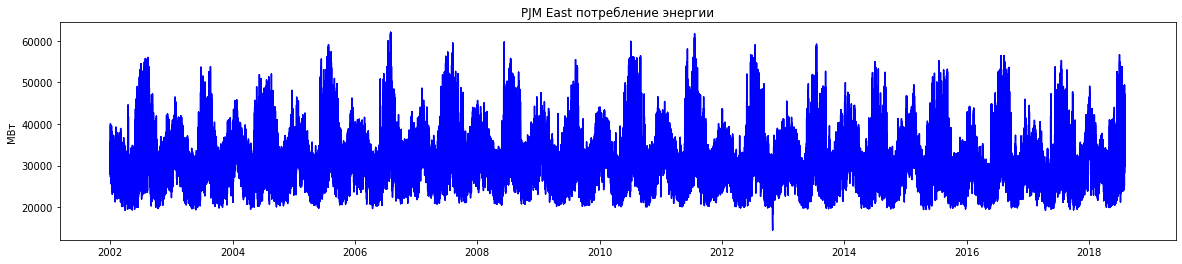

In [80]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

In [81]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA


In [82]:
# сделаем ресемплиннг на месяцы
data_m = data.resample('M').mean()

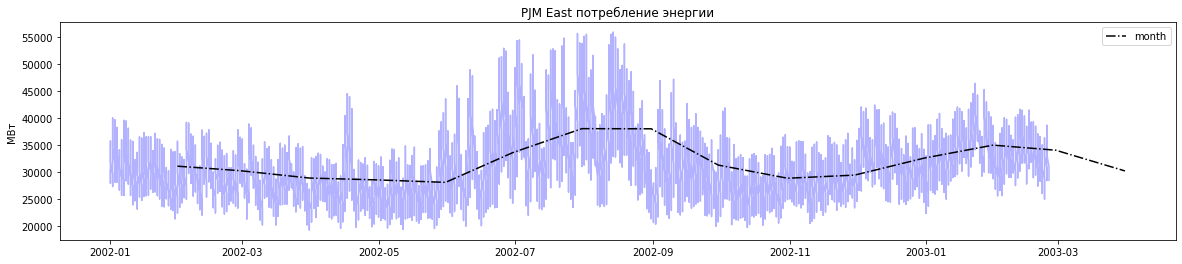

In [83]:
plt.figure(figsize =(20,4))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
#plt.plot( data_d.index[:5*7*4*3], data_d['PJME_MW'].values[:5*7*4*3], '--r',label='day' )
#plt.plot( data_w.index[:5*4*3], data_w['PJME_MW'].values[:5*4*3], 'g',label='week'  )
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month'  )
#plt.plot( data_Y.index[:5], data_Y['PJME_MW'].values[:5], '--m',label='3 month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

### Посмотрим на модель месячного ресемплинга. ACF

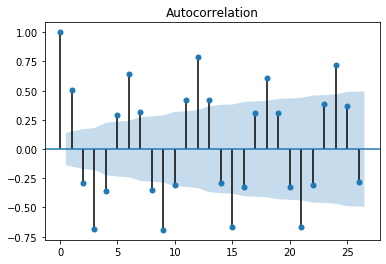

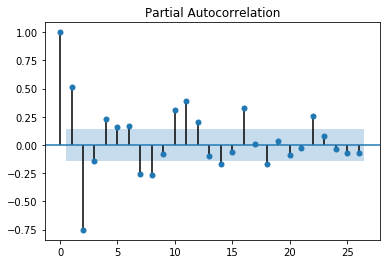

In [84]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=26)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=26)
plt.show()

Сохраняется корреляция для квартальных лагов (3, 6, 9 и 12 месяцы - это наши сезонные колебания - ACF) и для разностей важными являются значения внутри первых 3-х значений (PACF). Это позволит определить, что ряд сезонный и следует использовать модель сезонности с периодом 12, 6 или 3 месяца. диапазон поиска параметров модели ARIMA для лучшего описания нашего ряда в диапазоне до первых разностей и сглаживаний первого порядка.

Обсудим результаты анализа ACF,PACF.

__Общая рекомендация для оценки параметров:__

p = 1 : ACF - экспоненциально убывает, PACF - имеет резко выделяющееся значение для лага 1, нет корреляций на других лагах.

p = 2 : ACF имеет форму синусоиды или экспоненциально убывает, PACF имеет резко выделяющиеся значения на лагах 1, 2, нет корреляций на других лагах.

q = 1: ACF имеет резко выделяющееся значение на лаге 1, нет корреляций на других лагах, PACF экспоненциально убывает.

q = 2: ACF имеет резко выделяющиеся значения на лагах 1, 2, нет корреляций на других лагах, PACF имеет форму синусоиды или экспоненциально убывает.

p = 1 и q = 1: ACF экспоненциально убывает с лага 1, PACF - экспоненциально убывает с лага 1.

В сезонных рядах ACF и PACF имеют существенные значения на лагах, кратных сезонному лагу.

Рассмотрим результаты моделирования ряда с потенциально хорошими значениями порядками компонент нашего ряда с учетом сезонности в модификации SARIMAX, которая кроме всего прочего строит сезонную составляющую ряда. Фактически строим 3 модели : тренд, модель сезона и модель вокруг сезонных колебаний. А наш ряд очевидно сезонный. В качестве метрики качества используем информационный критерий Акаике (AIC) - чем меньше, тем лучше.

Обозначения для модели включают указание порядка для моделей AR (p), I (d) и MA (q) в качестве параметров функции ARIMA и AR (P), I (D), MA (Q) и m. параметры на сезонном уровне, например SARIMA (p, d, q) (P, D, Q) m, где «m» - количество временных шагов в каждом сезоне (сезонный период). Модель SARIMA может использоваться для разработки моделей AR, MA, ARMA и ARIMA. Принципиально формат обращения остается прежним (как у ARIMA), за исключением добавки сезонных параметров SARIMAX(<данные - массив ряда>,order=[p,d,q], seasonal_order=[ps,ds,qs])

Запустим вариант модели:

In [85]:
import warnings

# Определим p, d и q 
p = 1
d = 2
q = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с месячными данными, тогда сезонность это 12 месяцев
ps = 0
ds = 0
qs = 1
seasonal_pdq = [ps, ds, qs ,12] 


In [86]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [1, 2, 2]    : ps,ds,qs, S= [0, 0, 1, 12]


In [87]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-3],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))


SARIMAX[1, 2, 2]x[0, 0, 1, 12] - AIC:3368.3168917146513


In [88]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  197
Model:             SARIMAX(1, 2, 2)x(0, 0, 1, 12)   Log Likelihood               -1679.158
Date:                            Tue, 04 Aug 2020   AIC                           3368.317
Time:                                    14:43:45   BIC                           3384.282
Sample:                                         0   HQIC                          3374.790
                                            - 197                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

Анализ результатов по results:
- коэффициенты при элементах модели имеют большие значения (особенно важны составляющие сглаживания coef: ma.L1, ma.L2)
- можно посмотреть на остатки ряда (results.resid) с точки зрения автокорреляции и убедиться, что они не имеют значительной корреляции (это хорошо, т.к. остатки имеют характер белого шума)

In [89]:
results.resid[:10]

array([ 31075.39973082, -19644.46149359, -13716.88248792, -11667.97466466,
        -9343.02249593,  -1516.0405418 ,  -3472.90712157,  -6491.76085683,
       -11086.82483881,  -3159.36329979])

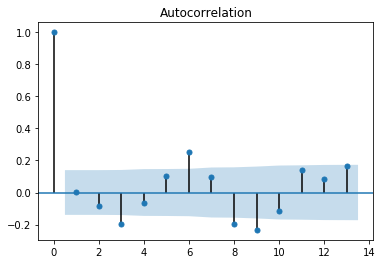

In [90]:
sm.graphics.tsa.plot_acf(results.resid, lags=13)
plt.show()

Оценим близости распределений остатков модели к нормальному закону используя визуализацию plot_diagnostics: 
- левый верхний график - остатки ряда 
- правый верхний - гистограмма для остатков ряда
- левый нижний - упорядоченное распределение остатков (квантильное)
- правый нижний - коррелограмма остатков

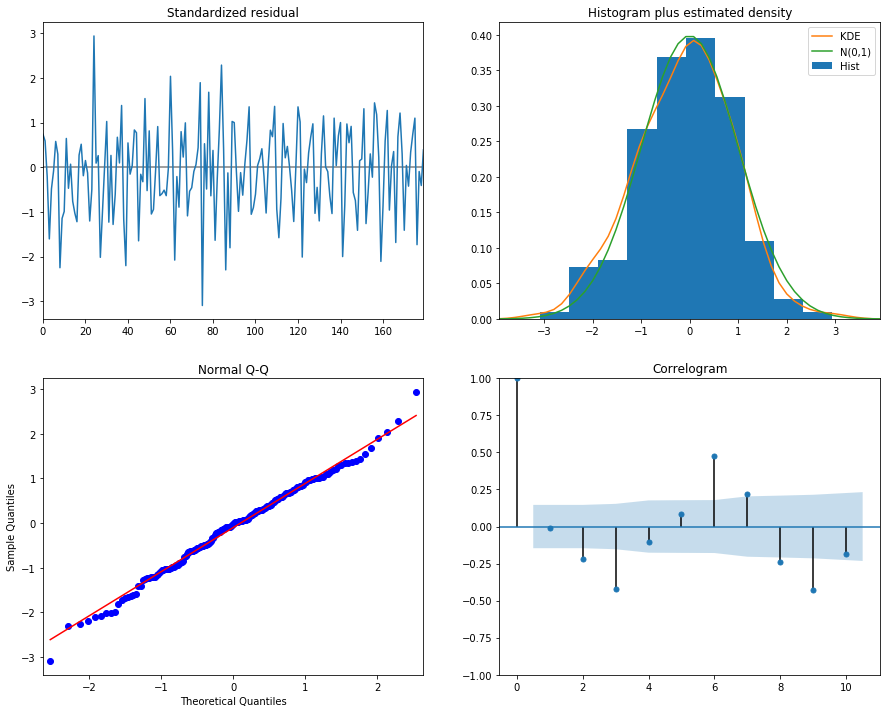

In [91]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


В этом случае диагностика показала, что остатки модели правильно распределяются:
- estimated density на верхнем-правом графике красная линия KDE находится близко к линии N (0,1) (где N (0,1) является стандартным обозначением нормального распределения со средним 0 и стандартным отклонением 1) . Очевидно, что остатки нормально распределены.
- График q-q в левом нижнем углу показывает, что упорядоченное распределение остатков (синие точки) следует линейному тренду выборок, взятых из стандартного распределения N (0, 1). Опять же, это признак того, что остатки нормально распределены.
- Остатки с течением времени (верхний левый график) не показывают явной сезонности и кажутся белыми шумами. Это подтверждается графиком автокорреляции (внизу справа), который показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими данными.

Эти графики позволяют сделать вывод о том, что выбранная модель (удовлетворительно) подходит для анализа и прогнозирования данных временных рядов.

## Подобрать параметры модели можно используя сеточный выбор как это сделано для ряда "Потребление энергии" ниже (работает долго!):

- На основании анализа выбираем диапазон изменения параметров сезонности и остатка ряда (для этой модели берем [0,3]).
    
- задаем длину сезона (12 - полный сезон или  6 месяцев - зимой греем, летом кондиционируем и расход энергии примерно одинаковый)
    
- Запускаем генерацию сетки с использованием модуля itertools (itertools.product(p, d, q) - сгенерит декартово множество по p,d,q диапазонам) и задаем полный список вариантов.
    
- Запускаем генерацию SARIMAX - с параметрами и возвращаем AIC.
    
- Лучшее значение параметров (при минимальной оценке AIC) используем для настройки финальной модели.

In [92]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [0] 
d = [0,1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[1]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (0, 0, 1, 12)


In [93]:
data_m['PJME_MW'].values.shape

(200,)

In [94]:
result_list=[]

Проведем исследование параметров в диапазонах "разумного" изменения параметров модели:

In [95]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[60:-30],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
            result_list.append([param, param_seasonal, results.aic])
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)3 - AIC:2575.6916834502176
ARIMA(0, 0, 0)x(0, 0, 1, 12)3 - AIC:2227.0822919879615
ARIMA(0, 0, 0)x(0, 0, 2, 12)3 - AIC:1917.861959430065
ARIMA(0, 0, 0)x(0, 1, 0, 12)3 - AIC:1750.2945128929255
ARIMA(0, 0, 0)x(0, 1, 1, 12)3 - AIC:1518.1985940519337
ARIMA(0, 0, 0)x(0, 1, 2, 12)3 - AIC:1297.2028814365005
ARIMA(0, 0, 1)x(0, 0, 0, 12)3 - AIC:2475.978991950559
ARIMA(0, 0, 1)x(0, 0, 1, 12)3 - AIC:2263.2232222728576
ARIMA(0, 0, 1)x(0, 0, 2, 12)3 - AIC:2797.8315338228463
ARIMA(0, 0, 1)x(0, 1, 0, 12)3 - AIC:1722.9811699117156
ARIMA(0, 0, 1)x(0, 1, 1, 12)3 - AIC:1494.6185108129434
ARIMA(0, 0, 1)x(0, 1, 2, 12)3 - AIC:1317.7758532168937
ARIMA(0, 0, 2)x(0, 0, 0, 12)3 - AIC:2436.581007590949
ARIMA(0, 0, 2)x(0, 0, 1, 12)3 - AIC:2159.290232258121
ARIMA(0, 0, 2)x(0, 0, 2, 12)3 - AIC:1888.3492504608807
ARIMA(0, 0, 2)x(0, 1, 0, 12)3 - AIC:1707.169386315508
ARIMA(0, 0, 2)x(0, 1, 1, 12)3 - AIC:1477.04251888678
ARIMA(0, 0, 2)x(0, 1, 2, 12)3 - AIC:1510.4946367073087
ARIMA(0, 1, 0)x(0

ARIMA(2, 2, 1)x(0, 0, 1, 12)3 - AIC:1765.998849915471
ARIMA(2, 2, 1)x(0, 0, 2, 12)3 - AIC:1531.316837536536
ARIMA(2, 2, 1)x(0, 1, 0, 12)3 - AIC:1737.6705562158477
ARIMA(2, 2, 1)x(0, 1, 1, 12)3 - AIC:1481.0727503915489
ARIMA(2, 2, 1)x(0, 1, 2, 12)3 - AIC:3271.98382558331
ARIMA(2, 2, 2)x(0, 0, 0, 12)3 - AIC:1938.7154419327596
ARIMA(2, 2, 2)x(0, 0, 1, 12)3 - AIC:1713.611170169357
ARIMA(2, 2, 2)x(0, 0, 2, 12)3 - AIC:1492.116760188654
ARIMA(2, 2, 2)x(0, 1, 0, 12)3 - AIC:1715.6714056141914
ARIMA(2, 2, 2)x(0, 1, 1, 12)3 - AIC:1457.930711829585
ARIMA(2, 2, 2)x(0, 1, 2, 12)3 - AIC:3181.1580264170425


In [96]:
#result_list

Лучшие результаты на недельных данных параметры модели SARIMA(0, 1, 2)x(0, 1, 2, 12)3 - AIC:1238.104 (для p,q,d,ps,ds,qs из диапазона [0,1,2]).

In [97]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения
N1 =6   # берем дданные не от начала - так быстрее работает
N2=12  # число точек для теста
nforecast = N2+30

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[N1:-N2],order=[0,1,2],
                                seasonal_order=[0,1,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)


AIC:{} 2495.1807923017896


Проведем моделирование прогноза на основе найденой SARIMAX[1, 2, 2]x[0, 0, 1, 12] - AIC:3368.32  и модели  SARIMA(0, 1, 2)x(0, 1, 2, 12)3 для последних 12 дней(и предсказание следующих 6 )  и сравним их с фактом.

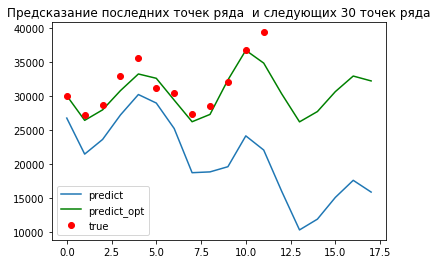

In [102]:
nforecast = N2+6  # полное число предиктов (тест+ чистый предикт)

pred_dynamic = results.forecast(nforecast)    #делаем предсказание на 30 точtк от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(nforecast)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-N2:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

In [103]:
results_opt.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.6960,0.098,-7.100,0.000,-0.888,-0.504
ma.L2,-0.3545,0.089,-3.999,0.000,-0.528,-0.181
ma.S.L12,-0.8207,0.087,-9.382,0.000,-0.992,-0.649
ma.S.L24,0.0544,0.067,0.810,0.418,-0.077,0.186
sigma2,2.001e+06,2.72e+05,7.360,0.000,1.47e+06,2.53e+06


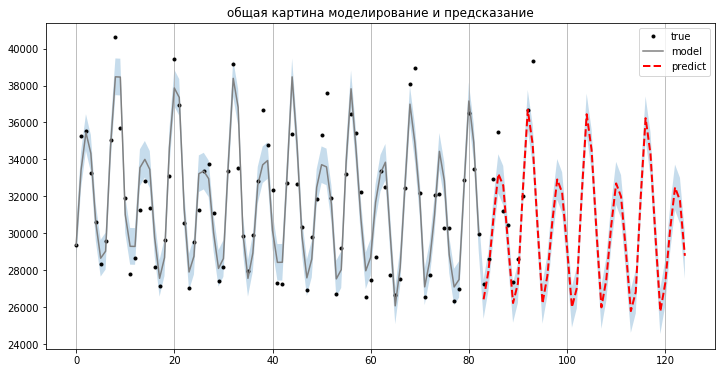

In [104]:
N3=100  # отступ данных для отображения  модели (для улучшения визуальных качеств рисунка - берем из интервала [0-500])
nforecast = N2+30  # общее число точек для предсказания (N2 - тестовых точек + точки для чистого предсказания)
predict_ = results_opt.get_prediction(end=results_opt.nobs + nforecast)  # делаем предсказание

# отображаем
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(data_m['PJME_MW'].values[N3+N1:], 'k.',label='true')

# 
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], 'gray',label = 'model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.25)
plt.legend()
ax.set(title='общая картина моделирование и предсказание');

Модель, которую выбрали по сетке, заметно лучше обходит точки известные нам заранее и имеет более сложный характер. Таким образом, подбор позволил улучшить исходный результат для ряда с сезонами и циклами. 

## Задание

- Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)

- Оцените результат моделирования
- Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.

In [105]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Text(0.5, 0, 't')

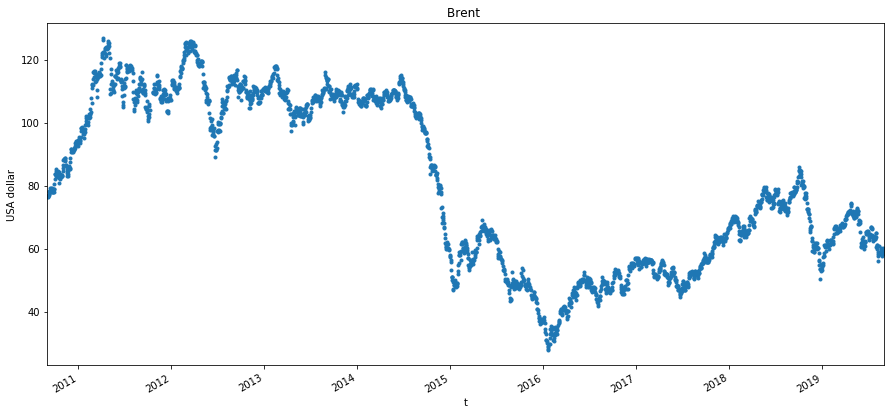

In [106]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

In [107]:
#сделаем недельный ресемплинг
brent_data_w = brent_data.resample("W").mean()
brent_data_w.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000


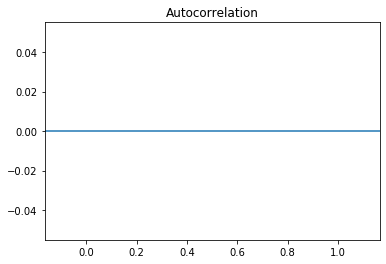

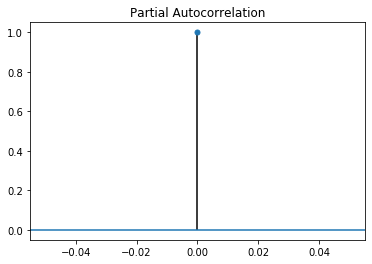

In [54]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(brent_data_w['Значение'].values, lags=30)
plt.show()
#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(brent_data_w['Значение'].values, lags=30)
plt.show()

## здесь у меня затруднения с интерпретацией визуализации

Построим ACF и PACF для первых разностей

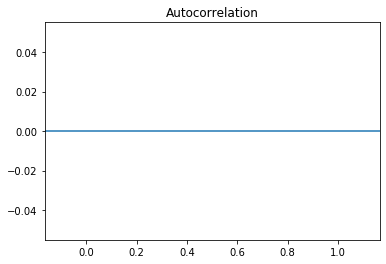

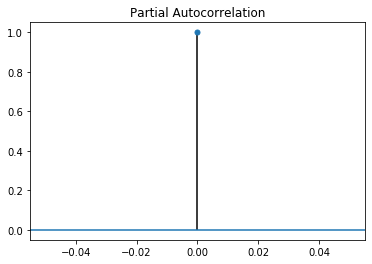

In [109]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
brent_dif = brent_data_w['Значение'].diff(1)

sm.graphics.tsa.plot_acf(brent_dif[1:], lags=30)
plt.show()
#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(brent_dif[1:], lags=30)
plt.show()

## здесь у меня затруднения с интерпретацией визуализации

Недельные графики показывают ....
Запустим модель без сезонного анализа (ARIMA)


In [110]:
# Определим p, d и q 
p = 2
d = 1
q = 1
pdq = [p, d, q]

N2=30
warnings.filterwarnings("ignore") # отключает предупреждения

modb = sm.tsa.statespace.SARIMAX(brent_data_w['Значение'].values[:-N2],
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb = modb.fit()
print('ARIMA{} - AIC:{}'.format(pdq, resultsb.aic))

print(resultsb.summary().tables[0],resultsb.summary().tables[1])

ARIMA[2, 1, 1] - AIC:1908.2969766060069
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  440
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -948.148
Date:                Tue, 04 Aug 2020   AIC                           1908.297
Time:                        14:50:48   BIC                           1932.777
Sample:                             0   HQIC                          1917.957
                                - 440                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   

Коэффициент модели  ar.L2 имеет малое абсолютное значение, что свидетельствует о том, что он не играет роли при определении ответа модели. посмотрим на визуализацию результатов работы модели, где видно, что остатки ряда распределены не одинаково на краях модели и в ее основной части, что не позволит принимать правильное решение (рис.Normal Q-Q, Standardized rezidual)

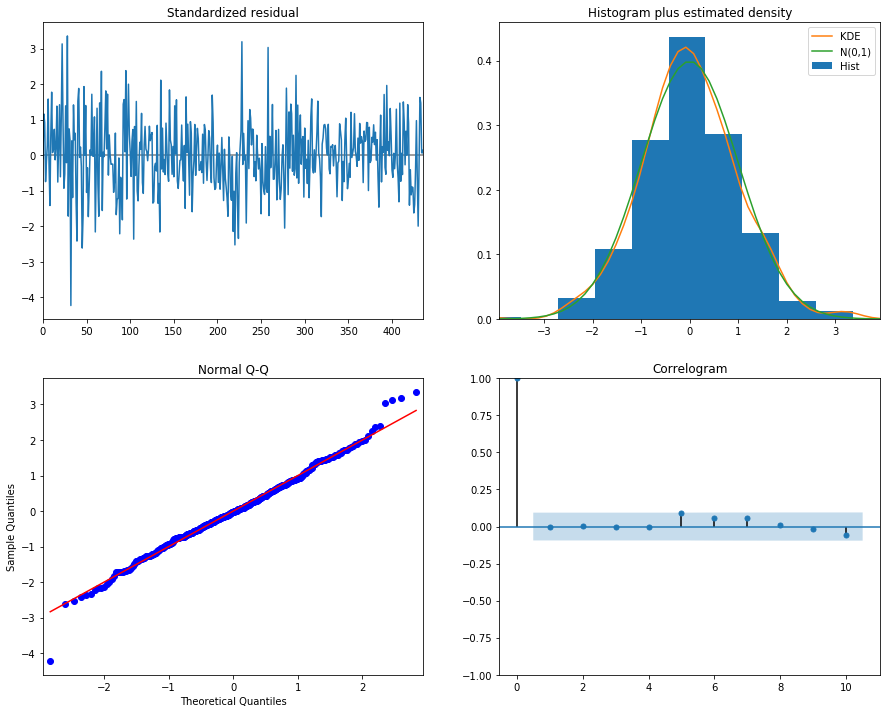

In [111]:
resultsb.plot_diagnostics(figsize=(15, 12))
plt.show()

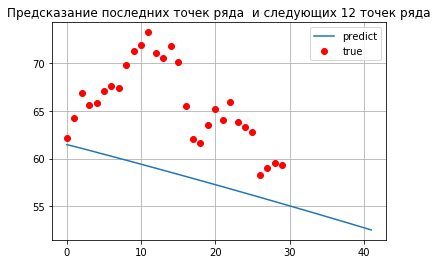

In [112]:
pred_dynamic = resultsb.forecast(42)    #делаем предсказание на 3 точки от текущего конца ряда

plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения 
plt.plot(brent_data_w['Значение'].values[-30:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 12 точек ряда')
plt.legend()
plt.grid()
plt.plot()
plt.show()

Для подбора оптимальных значений параметров модели временного ряда ARIMA (p, d, q), используем сеточный поиск

In [113]:
import itertools
# Определим p, d и q в диапазоне 0-3
d = [0,1]
p = [0,1] 
q = range(0, 7)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

warnings.filterwarnings("ignore") # отключает предупреждения

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_b = sm.tsa.statespace.SARIMAX(np.log(brent_data_w['Значение'].values[:-100]),
                                          order=param,seasonal_order=[0,0,0,0],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        results_ = mod_b.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
    except:
        continue

ARIMA(0, 0, 0)x[0, 0, 0, 0] - AIC:-34.36597445308726
ARIMA(0, 0, 1)x[0, 0, 0, 0] - AIC:-492.46683448071656
ARIMA(0, 0, 2)x[0, 0, 0, 0] - AIC:-810.3170988981226
ARIMA(0, 0, 3)x[0, 0, 0, 0] - AIC:-585.6023223267114
ARIMA(0, 0, 4)x[0, 0, 0, 0] - AIC:-1137.4731236221394
ARIMA(0, 0, 5)x[0, 0, 0, 0] - AIC:-1095.1385731862965
ARIMA(0, 0, 6)x[0, 0, 0, 0] - AIC:-1179.743718427973
ARIMA(0, 1, 0)x[0, 0, 0, 0] - AIC:-1455.0581244605282
ARIMA(0, 1, 1)x[0, 0, 0, 0] - AIC:-1490.5494066479462
ARIMA(0, 1, 2)x[0, 0, 0, 0] - AIC:-1483.6869561839135
ARIMA(0, 1, 3)x[0, 0, 0, 0] - AIC:-1478.7219259057056
ARIMA(0, 1, 4)x[0, 0, 0, 0] - AIC:-1472.5938864182344
ARIMA(0, 1, 5)x[0, 0, 0, 0] - AIC:-1465.5506408548222
ARIMA(0, 1, 6)x[0, 0, 0, 0] - AIC:-1463.4312678691954
ARIMA(1, 0, 0)x[0, 0, 0, 0] - AIC:-1463.2949926492452
ARIMA(1, 0, 1)x[0, 0, 0, 0] - AIC:-1498.9597246518047
ARIMA(1, 0, 2)x[0, 0, 0, 0] - AIC:-1492.0231228762077
ARIMA(1, 0, 3)x[0, 0, 0, 0] - AIC:-1486.505401831405
ARIMA(1, 0, 4)x[0, 0, 0, 0] - AIC

## Поиск по сетке определяет модель ARIMA(1, 1, 2)- AIC:-1435.01

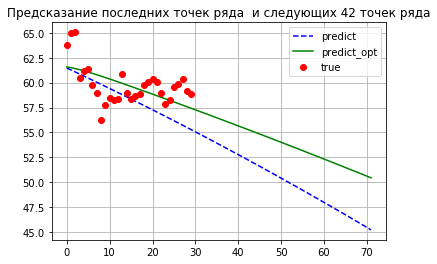

In [114]:

N2=30
nforecast = N2+42

modb_opt = sm.tsa.statespace.SARIMAX(brent_data_w['Значение'].values[:-N2],
                               order=[1,1,2],seasonal_order=[0,0,0,0],trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb_opt = modb_opt.fit()
pred_dynamic = resultsb.forecast(nforecast)    #делаем предсказание c 30 точки от текущего конца ряда
pred_dynamic_opt = resultsb_opt.forecast(72) 

plt.plot(pred_dynamic,'--b', label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(brent_data['Значение'].values[-N2:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 42 точек ряда')
plt.legend()
plt.grid()
plt.show()

Улучшеная модель ближе к первым по времени точкам выборки на отрезке предсказания. Однако общий результат моделирования еще далек от идеала. Проверим остатки модели.

In [115]:
resultsb_opt.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,0.0013,0.069,0.020,0.984,-0.133,0.136
drift,-8.477e-05,0.000,-0.244,0.807,-0.001,0.001
ar.L1,0.7595,0.269,2.821,0.005,0.232,1.287
ma.L1,-1.0949,0.652,-1.679,0.093,-2.373,0.183
ma.L2,-0.4414,0.164,-2.687,0.007,-0.763,-0.119
sigma2,2.2781,2.006,1.135,0.256,-1.654,6.211


Посмотрим на модель на этапе предсказания и этапе описания данных

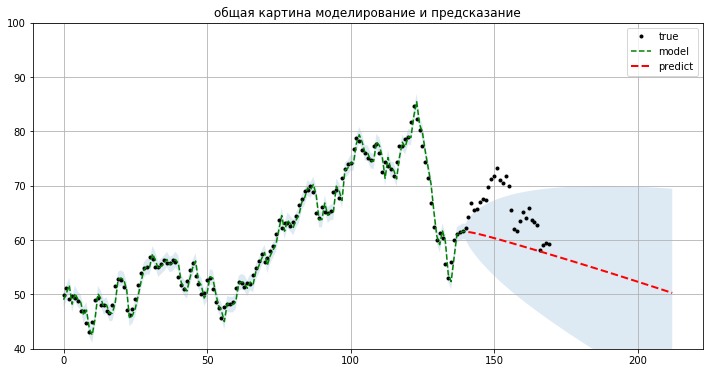

In [116]:
N2=30 # число точек для теста
nforecast = N2+42  # общее число точек для предсказания (тест+ чистое предсказание)
N3=300  # отступ от начала известной информации для визуализации - так виднее (можно брать 0-2600)
predict_ = resultsb_opt.get_prediction(end=resultsb_opt.nobs + nforecast)   
# получаем результаты работы модели по всей выборке

# отображаем результаты
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(brent_data_w['Значение'].values[N3:], 'k.',label='true')
plt.ylim([40,100])
plt.grid()
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], '--g',label='model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2,label = 'predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.15)
plt.legend()

ax.set(title='общая картина моделирование и предсказание');

In [117]:
adf_test = sm.tsa.stattools.adfuller(resultsb_opt.resid)
print(adf_test)


MissingDataError: exog contains inf or nans

### ругается на присутствие INF

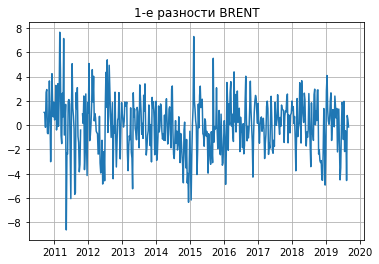

In [118]:
plt.plot(brent_dif)
plt.grid()
plt.title('1-е разности BRENT')
plt.show()

In [119]:


import itertools
# Определим p, d и q в диапазоне 0-3
d = [0,1]
p = [0,1] 
q = range(0,1)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

warnings.filterwarnings("ignore") # отключает предупреждения

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_bd = sm.tsa.statespace.SARIMAX(brent_dif[100:-100],order=param,seasonal_order=[0,0,0,0],
                                          stepwise=False, approximation=False, max_order=2)

        results_ = mod_bd.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
    except:
        continue

ARIMA(0, 0, 0)x[0, 0, 0, 0] - AIC:1154.2571003854814
ARIMA(0, 1, 0)x[0, 0, 0, 0] - AIC:1221.7030145430701
ARIMA(1, 0, 0)x[0, 0, 0, 0] - AIC:1121.2971359579892
ARIMA(1, 1, 0)x[0, 0, 0, 0] - AIC:1202.2072687067061


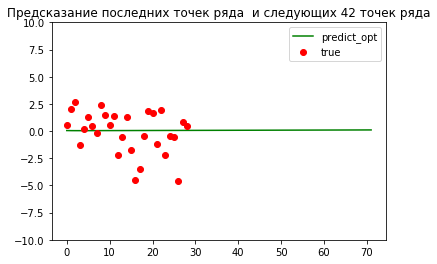

In [120]:
N1=100
N2=30
nforecast = N2+42
modb_optd = sm.tsa.statespace.SARIMAX(brent_dif[N1:-N2],
                               order=[1,0,0],seasonal_order=[0,0,0,0],trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb_optd = modb_optd.fit()
#делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = resultsb_optd.forecast(nforecast) 

plt.plot(pred_dynamic_opt.values,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(brent_dif.values[-N2:-1],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 42 точек ряда')
plt.ylim([-10,10])
plt.legend()
plt.plot()
plt.show()

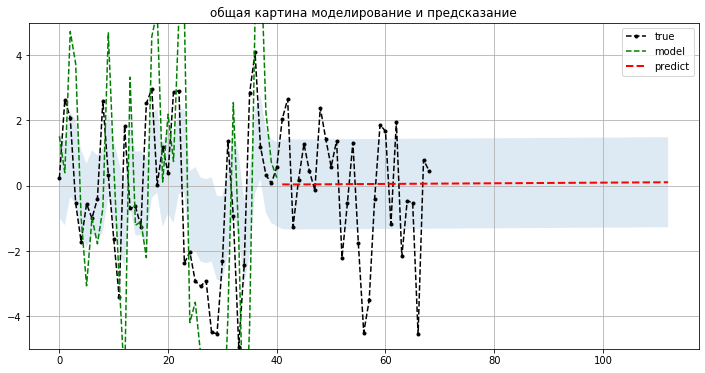

In [121]:
N3 = 300
predict_ = resultsb_optd.get_prediction(end=resultsb_optd.nobs + nforecast)   
# получаем результаты работы модели по всей выборке

# отображаем результаты
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(brent_dif.values[N3+N1:-1], '--k.',label='true')
plt.ylim([-5,5])
plt.grid()
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast]*5, '--g',label='model') # увеличена амплитуда в 5 раз - иначе не видно
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2,label = 'predict')
ax.fill_between(idx, predict_ci.iloc[N3:, 0], predict_ci.iloc[N3:, 1], alpha=0.15)
plt.legend()

ax.set(title='общая картина моделирование и предсказание');

Модель "Идеальна" , т.к. это случайное биение, которое ARIMA предсказывает очень хорошо (описываем параметры шума).

# Задание

Сделайте предположение о моделях, которые лучше работают с техниками регрессии  на основе AR I MA.